In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import scipy.integrate as integrate
import scipy.optimize as optimize
import numpy as np
import networkx as nx
from scipy.special import gamma,betaincinv
from scipy.stats import rv_continuous
from scipy.sparse import coo_matrix
from tqdm import tqdm

import sys
sys.path.append('../')
from src.rapidbetaprocess2 import rapidbeta
from src.threebetaprocess import threebeta, threebeta_vectorized
from src.edgesexchangeablegraph import edgesexchageablegraph, graphstatistics, numba_edgesexchageablegraph

In [2]:

def coo_to_networkx(coo_matrix):
    """
    Converts a graph represented as a COO matrix into a NetworkX graph.
    
    Parameters:
    - coo_matrix (scipy.sparse.coo_matrix): The adjacency matrix in COO format.
    
    Returns:
    - G (networkx.Graph): The corresponding NetworkX graph.
    """    
    # Create an empty undirected graph
    G = nx.Graph()
    
    # Add edges from COO matrix
    rows, cols, data = coo_matrix.row, coo_matrix.col, coo_matrix.data
    for u, v, w in zip(rows, cols, data):
        G.add_edge(u, v, weight=w)
    
    return G

In [3]:
def plot_degree(G, linespec='o', step=1, bins=16,fontsize=22,display=True):
    """
    plot_degree plots the degree of each node for the observed adjacency matrix G

    INPUT
      - G: observed binary adjacency matrix (scipy.sparse.coo_matrix)
      - linespec: line specification (determines line type, marker symbol, and color of the plotted lines)
      - step: step size for the logarithmic bin edges in the pdf of the degree distribution
      - fontsize: font size for the plot labels

    OUTPUT
      - fig: loglog degree distribution figure
      - ax: axis of the figure
      - centerbins: bin centers
      - freq: frequencies for the counts of the degrees in each bin
    """

    G = G.tocoo()  # Ensure G is in COO format
    G.data = np.nan_to_num(G.data, nan=0.5)  # fill missing by 0.5
    deg = np.array(G.sum(axis=0)).flatten()


    # Uses logarithmic binning to get a less noisy estimate of the
    # pdf of the degree distribution
    edgebins = 2.0 ** np.arange(0, bins + step, step)
    sizebins = edgebins[1:] - edgebins[:-1]

    centerbins = edgebins[:-1] #+ sizebins / 2
    counts, _ = np.histogram(deg, bins=edgebins)
    freq = counts / sizebins / G.shape[0]

    if display : 
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.loglog(centerbins, freq, linespec, alpha = 0.8,color="c")
        plt.xlabel('Degree', fontsize=fontsize)
        plt.ylabel('Distribution', fontsize=fontsize)
        #plt.grid(True, which="both", ls="--")

        #plt.show()
        return fig, ax, centerbins, freq, deg
    else : 
        return centerbins, freq, deg

In [4]:
c=40
b=1.2
a=0.8

W_3BP=threebeta_vectorized(c,b,a,2000)
print(W_3BP.shape[0])
print(W_3BP.sum())

80080
29.356170296945457


In [66]:
eta=10
ksi=1.02
cRapid=0.01

W_rapid=cRapid*rapidbeta(eta,ksi,truncation_level=2000)
print(W_rapid.shape[0])
print(W_rapid.sum())


8000
68.81234572019959


In [71]:
M= numba_edgesexchageablegraph(W_rapid,1)
nb_nodes, num_multi_edges, num_single_edges = graphstatistics(M)
print(f'Number of nodes: {nb_nodes}')
print(f'Number of multi-edges: {num_multi_edges} ')
print(f'Number of single edges: {num_single_edges}')

Number of nodes: 3447
Number of multi-edges: 2382 
Number of single edges: 2382


In [72]:
G=coo_to_networkx(M)
print(G.number_of_nodes())
print(G.number_of_edges())

3447
2382


In [ ]:
# Node positions using spring layout
pos = nx.random_layout(G, seed=42)

# Node degrees for size scaling
degrees = np.array([G.degree(n) for n in G.nodes()])
node_sizes = 20*degrees-10  # Scale node size by degree

# Colour nodes based on degree
# Colour nodes: darker for higher degree
# Colour nodes: darker shades of blue for higher degree
cmap = plt.colormaps["Blues"]
norm = mcolors.Normalize(vmin=1, vmax=100)
node_colors = [cmap(0.5+40*norm(deg)) for deg in degrees]


# Draw the graph
plt.figure(figsize=(8, 8),dpi=300)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes,node_color=node_colors, alpha=0.8)
# Draw curved edges
for edge in G.edges():
    node1, node2 = edge
    rad = 0.2  # Controls the curvature
    edge_patch = mpatches.FancyArrowPatch(
        pos[node1], pos[node2],
        connectionstyle=f"arc3,rad={rad}",
        color="black", alpha=0.1, lw=0.1
    )
    plt.gca().add_patch(edge_patch)
# Show the plot
plt.axis("off")
#plt.savefig("mGG_graph.png")
plt.show()

In [9]:
n_rep = 5  # Number of graph repetitions
nbstep = 10
bins=16


eta_min = 1
eta_max = 50

# Generate logarithmically spaced indices
ETA = np.unique(np.round(np.logspace(np.log10(eta_min), np.log10(eta_max), nbstep)).astype(int))
print(ETA)
nbstep = len(ETA)
print(nbstep)

[ 1  2  4  6  9 14 21 32 50]
9


In [10]:
Nb_Nodes_Rapid = np.zeros((n_rep, nbstep))
Nb_Multi_Edges_Rapid = np.zeros((n_rep, nbstep))
Nb_Single_Edges_Rapid = np.zeros((n_rep, nbstep))
FREQ_Rapid = np.zeros((n_rep, nbstep))


for i in range(n_rep):
   W_rapid=cRapid*rapidbeta(eta,ksi,truncation_level=2000)
   print(W_rapid.shape[0])
   print(W_rapid.sum())
   for j in tqdm(range(nbstep)):
      t=ETA[j]
      M= numba_edgesexchageablegraph(W_rapid,t)
      nb_nodes, num_multi_edges, num_single_edges = graphstatistics(M)
      Nb_Nodes_Rapid[i, j] = nb_nodes
      Nb_Multi_Edges_Rapid[i, j] = num_multi_edges
      Nb_Single_Edges_Rapid[i, j] = num_single_edges
      #centerbins, freq, deg = plot_degree(M, bins=bins, display=False)
      #FREQ_Rapid[i,j] = freq[0]

44000
11.01715019490107


100%|██████████| 9/9 [01:23<00:00,  9.29s/it]


70000
23.810469263390196


100%|██████████| 9/9 [03:30<00:00, 23.39s/it]


70000
26.14823147050169


100%|██████████| 9/9 [03:24<00:00, 22.77s/it]


94000
28.678407458944346


100%|██████████| 9/9 [06:11<00:00, 41.29s/it]


84000
28.914243068596267


100%|██████████| 9/9 [18:22<00:00, 122.55s/it]


In [11]:
Nb_Nodes_3BP = np.zeros((n_rep, nbstep))
Nb_Multi_Edges_3BP = np.zeros((n_rep, nbstep))
Nb_Single_Edges_3BP = np.zeros((n_rep, nbstep))
FREQ_3BP = np.zeros((n_rep, nbstep))


for i in range(n_rep):
   W_3BP=threebeta_vectorized(c,b,a,2000)
   print(W_3BP.shape[0])
   print(W_3BP.sum())
   for j in tqdm(range(nbstep)):
      t=ETA[j]
      M= numba_edgesexchageablegraph(W_3BP,t)
      nb_nodes, num_multi_edges, num_single_edges = graphstatistics(M)
      Nb_Nodes_3BP[i, j] = nb_nodes
      Nb_Multi_Edges_3BP[i, j] = num_multi_edges
      Nb_Single_Edges_3BP[i, j] = num_single_edges
      #centerbins, freq, deg = plot_degree(M, bins=bins, display=False)
      #FREQ_3BP[i,j] = freq[0]

79837
33.08202104481707


100%|██████████| 9/9 [07:44<00:00, 51.63s/it]


80132
32.15908376007926


100%|██████████| 9/9 [06:19<00:00, 42.17s/it] 


80010
31.49390919922786


100%|██████████| 9/9 [04:29<00:00, 29.96s/it]


80185
32.96371862997916


100%|██████████| 9/9 [04:28<00:00, 29.85s/it]


80263
32.67238549087411


100%|██████████| 9/9 [04:27<00:00, 29.77s/it]


In [14]:
Nb_Nodes_BA = np.zeros(nbstep)
Nb_Edges_BA = np.zeros(nbstep)
FREQ_BA = np.zeros(nbstep)

m = 1  # Number of edges per new node (adjustable)

for i in range(nbstep): 
    N= Nb_Nodes_3BP[0,i]
    # Generate a Barabási–Albert graph
    G = nx.barabasi_albert_graph(N, m)
    Nb_Nodes_BA[i] = G.number_of_nodes()
    Nb_Edges_BA[i] = G.number_of_edges()
    degree_one_nodes = sum(1 for _, d in G.degree() if d == 1)
    total_nodes = G.number_of_nodes()
    #FREQ_BA[i]= degree_one_nodes / total_nodes if total_nodes > 0 else 0


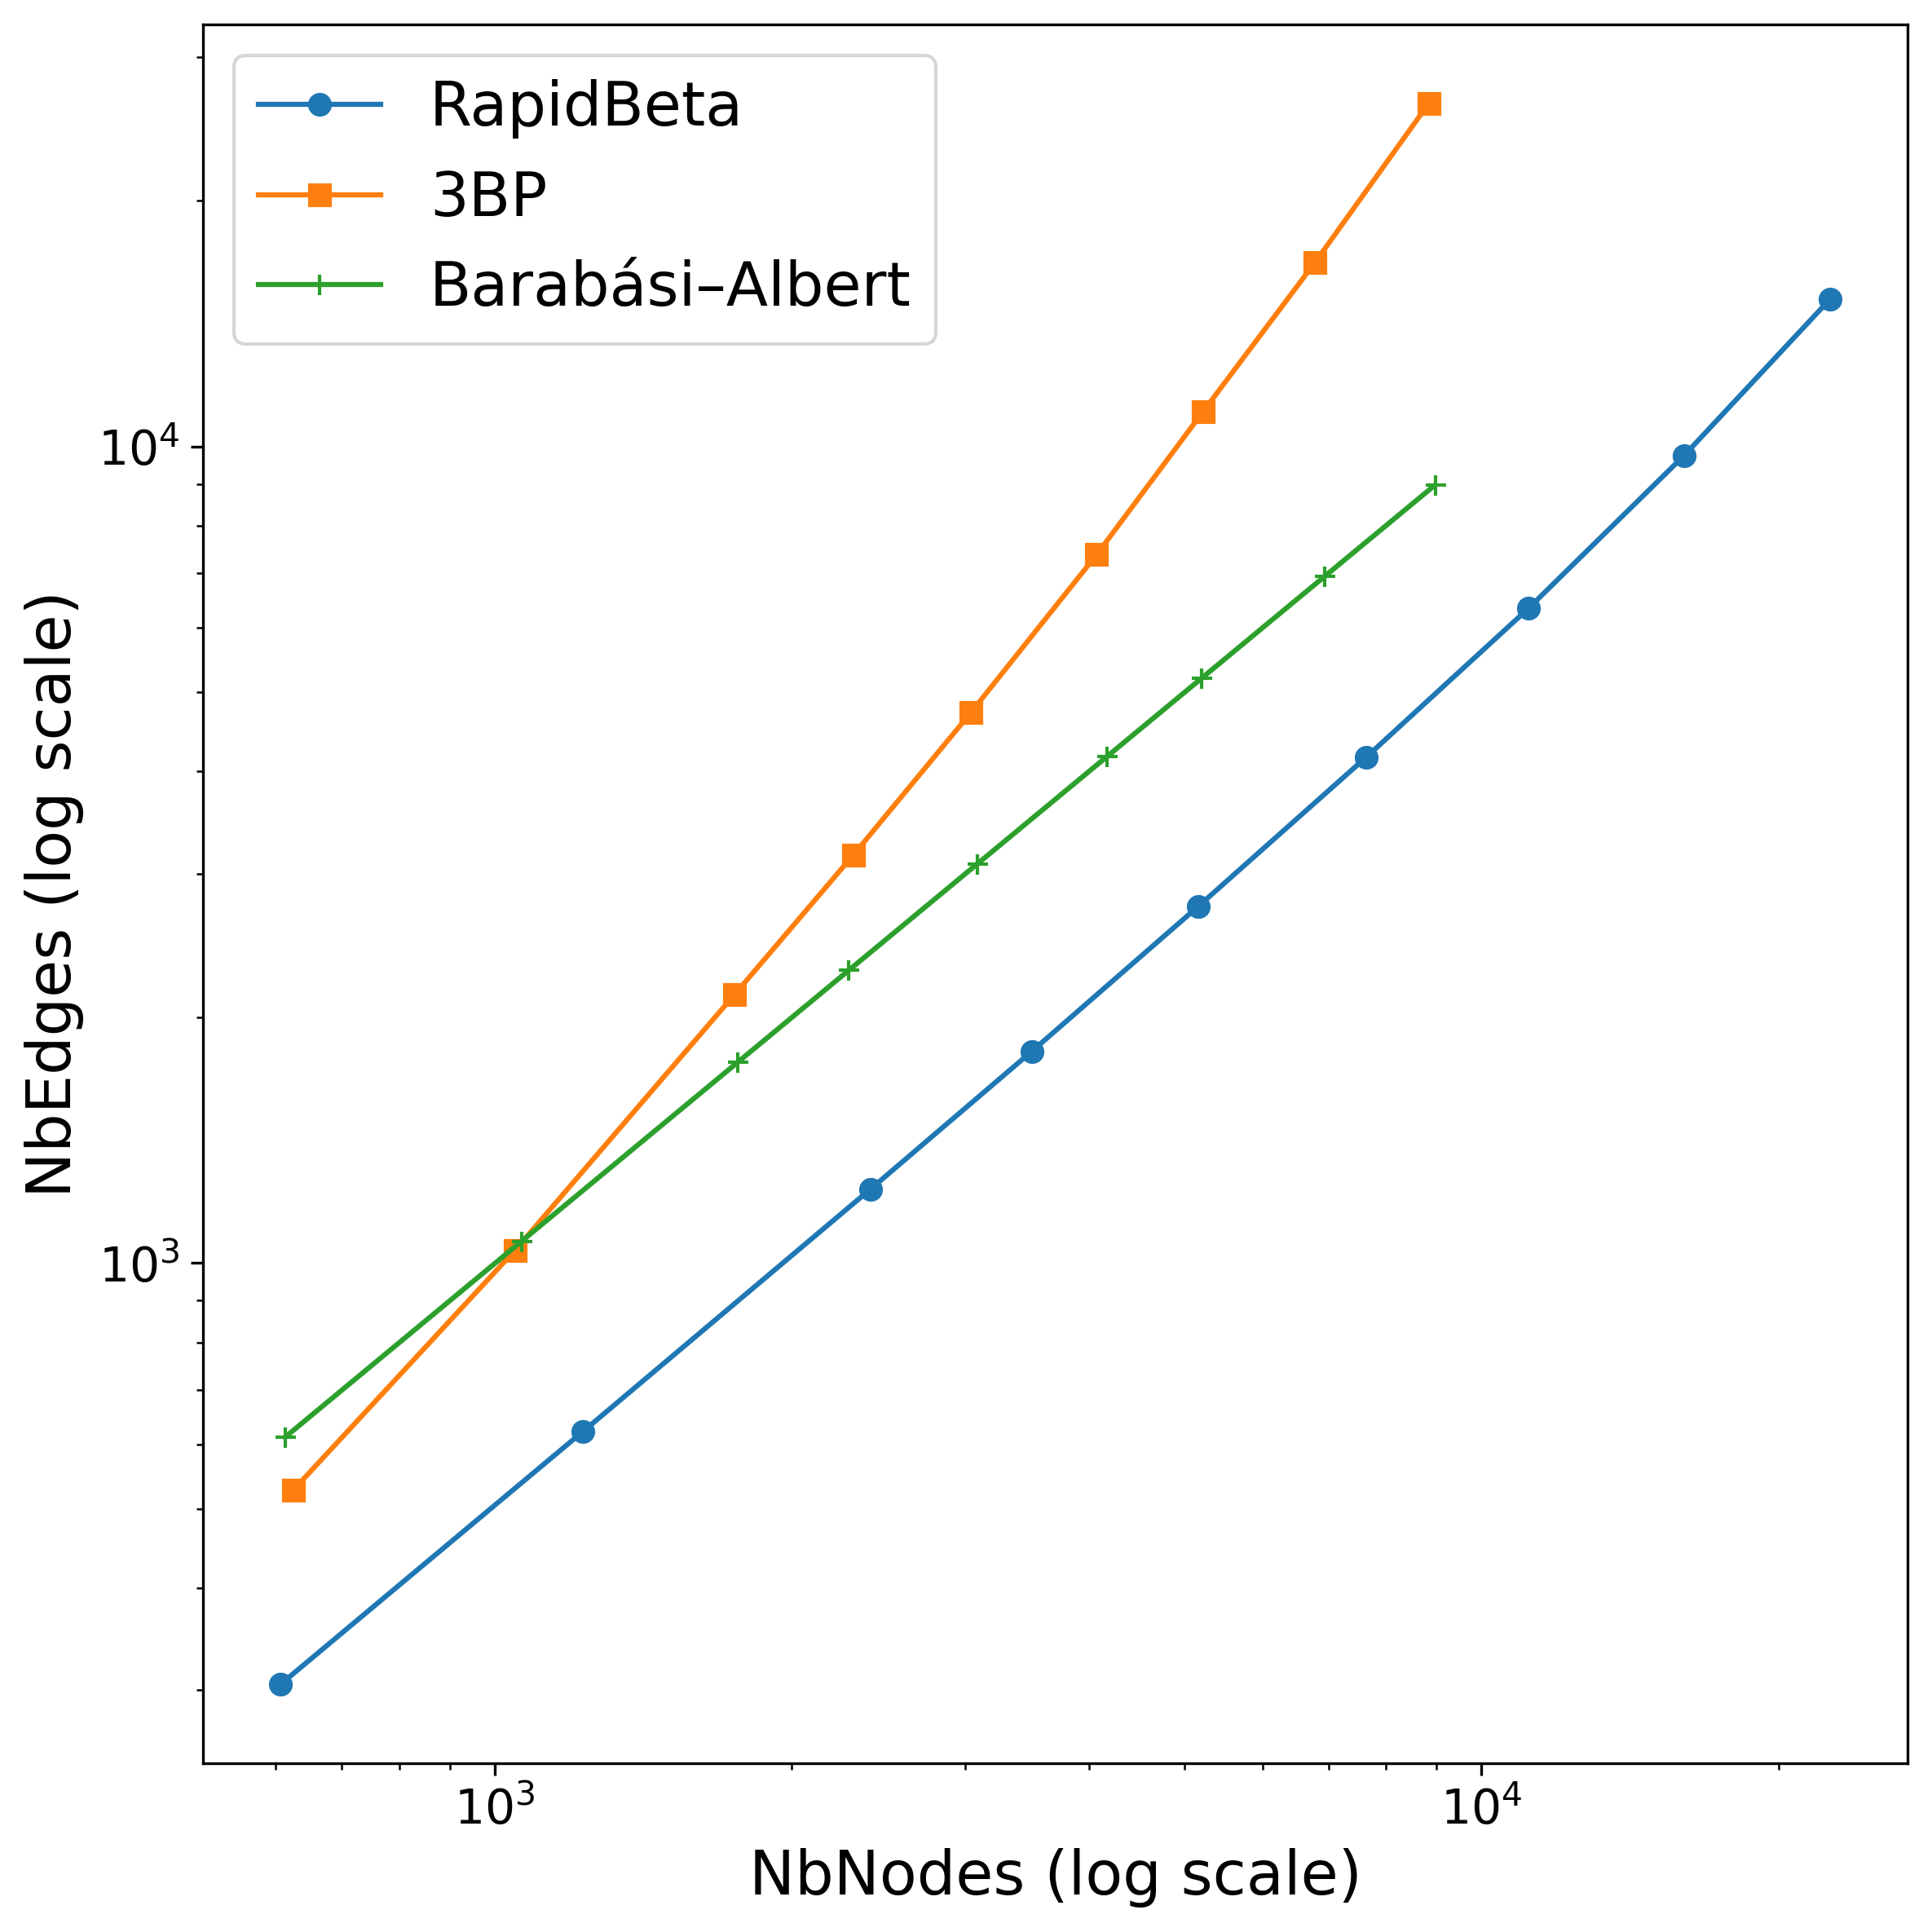

In [15]:
fig, ax = plt.subplots(dpi=300, figsize=(8, 8))

# Compute means
mean_NbNodes_Rapid = np.mean(Nb_Nodes_Rapid, axis=0)
mean_Nb_Multi_Edges_Rapid = np.mean(Nb_Multi_Edges_Rapid, axis=0)
mean_Nb_Single_Edges_Rapid = np.mean(Nb_Single_Edges_Rapid, axis=0)

mean_NbNodes_3BP = np.mean(Nb_Nodes_3BP, axis=0)
mean_Nb_Multi_Edges_3BP = np.mean(Nb_Multi_Edges_3BP, axis=0)
mean_Nb_Single_Edges_3BP = np.mean(Nb_Single_Edges_3BP, axis=0)

#for i in range(nbstep): 
#    plt.plot(Nb_Nodes_Rapid[0,i],Nb_Multi_Edges_Rapid[0,i],marker='o',linestyle='-',color='tab:red' )
# Plot mean points with different markers
plt.plot(mean_NbNodes_Rapid, mean_Nb_Multi_Edges_Rapid, marker='o', linestyle='-', color='tab:blue', label=r"RapidBeta")
#plt.plot(mean_NbNodes_Rapid, mean_Nb_Single_Edges_Rapid, marker='+', linestyle='-', color='tab:blue', label=r"Rapid-single")


plt.plot(mean_NbNodes_3BP, mean_Nb_Multi_Edges_3BP, marker='s', linestyle='-', color='tab:orange', label=r"3BP")
#plt.plot(mean_NbNodes_3BP, mean_Nb_Single_Edges_3BP, marker='+', linestyle='-', color='tab:red', label=r"3BP-single")


plt.plot(Nb_Nodes_BA, Nb_Edges_BA, marker='+', linestyle='-', color='tab:green', label=r"Barabási–Albert")

# Log-log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Labels and limits
ax.set_xlabel('NbNodes (log scale)', fontsize=18)
ax.set_ylabel('NbEdges (log scale)', fontsize=18)
#ax.set_xlim(10, 10**5)
#ax.set_ylim(10, 10**5)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.legend(fontsize=18)
plt.savefig('NbNodesNbEdges.png')
plt.show()


In [16]:
np.save('Nb_Nodes_3BP.npy', Nb_Nodes_3BP)
np.save('Nb_Multi_Edges_3BP.npy', Nb_Multi_Edges_3BP)
np.save('Nb_Single_Edges_3BP.npy', Nb_Single_Edges_3BP)
np.save('Nb_Nodes_Rapid.npy', Nb_Nodes_Rapid)
np.save('Nb_Multi_Edges_Rapid.npy', Nb_Multi_Edges_Rapid)
np.save('Nb_Single_Edges_Rapid.npy', Nb_Single_Edges_Rapid)